# Grad-CAM
TensorFlow 2.X implementation of [Grad-CAM](https://arxiv.org/pdf/1610.02391.pdf), an approach for model explainability which produces a heatmap of which regions of an image contributed strongly towards the final prediction.

In [1]:
%matplotlib inline

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.resnet50 import (
    ResNet50,
    preprocess_input,
    decode_predictions,
)
import cv2

The Grad-CAM output is an activation map which localises the detected objected to a region in the image. It is of width $u$ and height $v$, for the class $c$.
$$
L^{c}_{\textrm{Grad-CAM}} \in \mathbb{R}^{u \times v}
$$

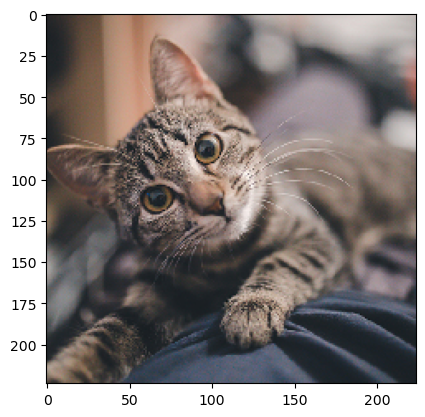

In [6]:
image = np.array(load_img("../data/cat.jpg", target_size=(224, 224, 3)))
plt.imshow(image)

In [7]:
model = ResNet50()

In [8]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

We get the output of the last convolution layer. We then create a model that goes up to only that layer.

In [9]:
last_conv_layer = model.get_layer("conv5_block3_out")
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

This line is creating a new Keras model that uses the same inputs as the original model but has its output at the "conv5_block3_out" layer. This effectively creates a new model that includes all layers of the original model up to and including "conv5_block3_out".

So, in other words, the new model last_conv_layer_model is a truncated version of the original model (ResNet50 in this case). It contains all layers from the input up to the last convolutional block. This model can be used to obtain the output of the last convolutional layer of the original ResNet50 model when you pass an image (or batch of images) through it, which are the high-level features learned by the ResNet50 model.

In [11]:
last_conv_layer_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

We create a model which then takes the output of the model above, and uses the remaining layers to get the final predictions.

In [13]:
last_conv_layer.output.shape

TensorShape([None, 7, 7, 2048])

In [14]:
last_conv_layer

In [16]:
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in ["avg_pool", "predictions"]:
    x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

In [20]:
classifier_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 7, 7, 2048)]      0         
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 1000)              2049000   
Total params: 2,049,000
Trainable params: 2,049,000
Non-trainable params: 0
_________________________________________________________________


First, we get the output from the model up till the last convolution layer.
We ask `tf` to watch this tensor output, as we want to calculate the gradients of the predictions of our target class wrt to the output of this model (last convolution layer model).

In [52]:
with tf.GradientTape() as tape:
    inputs = image[np.newaxis, ...]
    last_conv_layer_output = last_conv_layer_model(inputs)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output) #(1,1000)
    top_pred_index = tf.argmax(preds[0]) # 287
    top_class_channel = preds[:, top_pred_index] # 0.32

The partial derivative / gradient of the model output (logits / prior to softmax), $y^{c}$, with respect to the feature map (filter) activations of a specified convolution layer (the last convolution layer in this case) is:
$$
\frac{\partial y^{c}}{\partial A^{k}_{ij}}
$$

In [53]:
grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [54]:
grads.shape

TensorShape([1, 7, 7, 2048])

The gradients have a shape of `(u,v,Z)`, where `(u,v)` comes from the shape of the 2D convolution filter (i.e. width and height), and `Z` is the number of filters. The next step averages each of the filters to a single value, so that the final shape is `Z` or the number of filters. This is equivalent to the global average pooling 2D layer.

$$
\alpha_{k}^{c}=\frac{1}{Z}\sum_{i}\sum_{j}\frac{\partial y^{c}}{\partial A^{k}_{ij}}
$$

Each one of these gradients represents the connection from one of the pixels in the 2D array to the neuron / output representing the target class.

In [55]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

In [56]:
pooled_grads

<tf.Tensor: shape=(2048,), dtype=float32, numpy=
array([ 4.8028534e-05,  1.0569749e-04,  5.0926206e-05, ...,
       -1.1526734e-04,  8.0925893e-06,  8.0580379e-05], dtype=float32)>

This is what the next layer in the model does which is a global average pooling 2D layer, which  averages and flattens the $z$ number of filters of $u \times v$ shape to single numbers (exactly what we did in previous step). This is necessary to create a connection to the fully connected (Dense) layers for the final prediction outputs.

The next step is to multiply the gradients (corresponding to the importance of the given feature map / filter) with the actual feature map (filter) it represents.

$$
ReLU\bigg(\sum_{k} a^{c}_{k}A^{k}\bigg)
$$

In [57]:
last_conv_layer_output.numpy()[0].shape

(7, 7, 2048)

In [58]:
pooled_grads.shape[-1]

2048

In [59]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]): #2048
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [60]:
# Average over all the filters to get a single 2D array
gradcam = np.mean(last_conv_layer_output, axis=-1)
# Clip the values (equivalent to applying ReLU)
# and then normalise the values
gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)


In [65]:
gradcam = cv2.resize(gradcam, (224, 224))

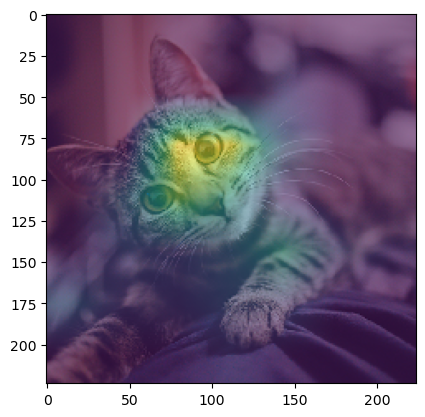

In [66]:
plt.imshow(image)
plt.imshow(gradcam, alpha=0.5)

# Counterfactual explanation

By negating the value of $\frac{\partial y^{c}}{\partial A^{k}}$, we can produce a map of regions that would lower the network's confidence in its prediction. This is useful when two competing objects are present in the image. We can produce a "counterfactual" image with these regions masked out, which should give a higher confidence in the original prediction.

In [67]:
multiobject_image = np.array(
    load_img("../data/cat_and_dog.jpg", target_size=(224, 224, 3))
)

In [68]:
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(multiobject_image[np.newaxis, ...])
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [69]:
grads = tape.gradient(top_class_channel, last_conv_layer_output)

The negative of the gradients is taken, to target the regions that do not contribute towards strengthen the network's predictions.

In [70]:
pooled_grads = tf.reduce_mean(-1 * grads, axis=(0, 1, 2))

In [71]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [72]:
# Average over all the filters to get a single 2D array
ctfcl_gradcam = np.mean(last_conv_layer_output, axis=-1)
# Normalise the values
ctfcl_gradcam = np.clip(ctfcl_gradcam, 0, np.max(ctfcl_gradcam)) / np.max(ctfcl_gradcam)
ctfcl_gradcam = cv2.resize(ctfcl_gradcam, (224, 224))

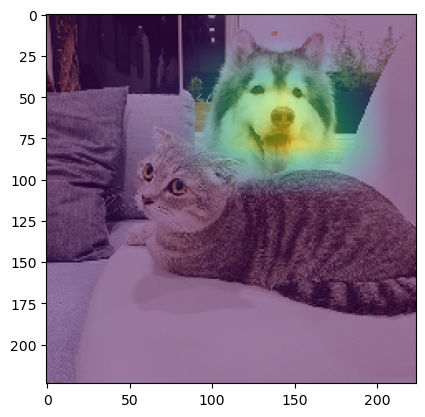

In [73]:
plt.imshow(multiobject_image)
plt.imshow(ctfcl_gradcam, alpha=0.5)

We can mask out the region identified by the counterfactual map, and re-run the predictions, where we should see a higher confidence in the outputs.

In [74]:
mask = cv2.resize(ctfcl_gradcam, (224, 224))
mask[mask > 0.1] = 255
mask[mask != 255] = 0
mask = mask.astype(bool)

In [75]:
ctfctl_image = multiobject_image.copy()
ctfctl_image[mask] = (0, 0, 0)

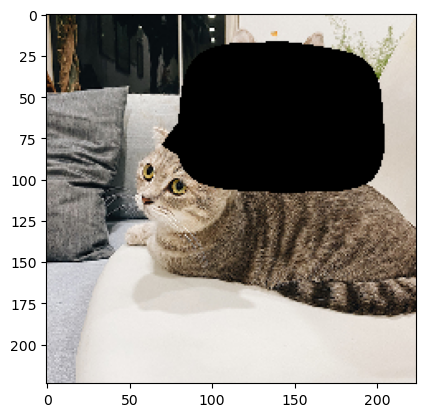

In [76]:
plt.imshow(ctfctl_image)

In [80]:
image[np.newaxis, ...].shape

(1, 224, 224, 3)

In [81]:
decode_predictions

<function tensorflow.python.keras.applications.resnet.decode_predictions(preds, top=5)>

In [77]:
decode_predictions(model.predict(image[np.newaxis, ...]))

2023-07-10 16:15:18.095130: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


40960/35363 [==================================] - 0s 1us/step


[[('n02127052', 'lynx', 0.32931602),
  ('n02123045', 'tabby', 0.18094625),
  ('n02123159', 'tiger_cat', 0.1474289),
  ('n02124075', 'Egyptian_cat', 0.09377928),
  ('n02128757', 'snow_leopard', 0.036031626)]]

In [78]:
decode_predictions(model.predict(ctfctl_image[np.newaxis, ...]))

[[('n02124075', 'Egyptian_cat', 0.6026158),
  ('n02123045', 'tabby', 0.040005792),
  ('n04254777', 'sock', 0.036930993),
  ('n02834397', 'bib', 0.03177831),
  ('n03814639', 'neck_brace', 0.017811818)]]

---

# Guided Grad-CAM

The Grad-CAM output can be improved further by combining with guided backpropagation, which zeroes elements in the gradients which act negatively towards the decision. Implementation from Raphael Meudec / [Sicara](https://www.sicara.ai/blog/2019-08-28-interpretability-deep-learning-tensorflow), [GitHub Gist](https://gist.github.com/RaphaelMeudec/e9a805fa82880876f8d89766f0690b54).

This output, however, is still a low resolution heatmap, and not quite as described in the original paper. The original paper

In [83]:
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(image[np.newaxis, ...])
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [84]:
grads = tape.gradient(top_class_channel, last_conv_layer_output)[0]
last_conv_layer_output = last_conv_layer_output[0]

Guided backpropagation implementation:

In [85]:
guided_grads = (
    tf.cast(last_conv_layer_output > 0, "float32")
    * tf.cast(grads > 0, "float32")
    * grads
)

In [86]:
pooled_guided_grads = tf.reduce_mean(guided_grads, axis=(0, 1))
guided_gradcam = np.ones(last_conv_layer_output.shape[:2], dtype=np.float32)

In [87]:
pooled_guided_grads.shape

TensorShape([2048])

In [88]:
for i, w in enumerate(pooled_guided_grads):
    guided_gradcam += w * last_conv_layer_output[:, :, i]

In [31]:
guided_gradcam = cv2.resize(guided_gradcam.numpy(), (224, 224))

In [33]:
guided_gradcam = np.clip(guided_gradcam, 0, np.max(guided_gradcam))
guided_gradcam = (guided_gradcam - guided_gradcam.min()) / (
    guided_gradcam.max() - guided_gradcam.min()
)

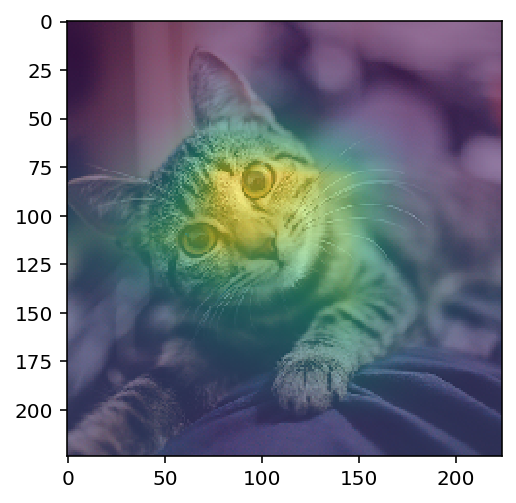

In [34]:
plt.imshow(image)
plt.imshow(guided_gradcam, alpha=0.5)

---

# Guided Grad-CAM (high resolution maps)
This approach reflects the paper's description better by first using the guided backpropagation approach to produce a high resolution map that is of the same resolution of the input image, which is then masked using the Grad-CAM heatmap to focus only on details that led to the prediction outcome. Based on the implementation on GitHub by [jacobgil](https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py).

In [35]:
@tf.custom_gradient
def guided_relu(x):
    def grad(dy):
        return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy

    return tf.nn.relu(x), grad

In [36]:
class GuidedBackprop:
    def __init__(self, model, layer_name: str):
        self.model = model
        self.layer_name = layer_name
        self.gb_model = self.build_guided_model()

    def build_guided_model(self):
        gb_model = tf.keras.Model(
            self.model.inputs, self.model.get_layer(self.layer_name).output
        )
        layers = [
            layer for layer in gb_model.layers[1:] if hasattr(layer, "activation")
        ]
        for layer in layers:
            if layer.activation == tf.keras.activations.relu:
                layer.activation = guided_relu
        return gb_model

    def guided_backprop(self, image: np.ndarray):
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            tape.watch(inputs)
            outputs = self.gb_model(inputs)
        grads = tape.gradient(outputs, inputs)[0]
        return grads

In [37]:
gb = GuidedBackprop(model, "conv5_block3_out")

In [39]:
saliency_map = gb.guided_backprop(image[np.newaxis, ...]).numpy()
saliency_map = saliency_map * np.repeat(guided_gradcam[..., np.newaxis], 3, axis=2)

In [40]:
saliency_map -= saliency_map.mean()
saliency_map /= saliency_map.std() + tf.keras.backend.epsilon()
saliency_map *= 0.25
saliency_map += 0.5
saliency_map = np.clip(saliency_map, 0, 1)
saliency_map *= (2 ** 8) - 1
saliency_map = saliency_map.astype(np.uint8)

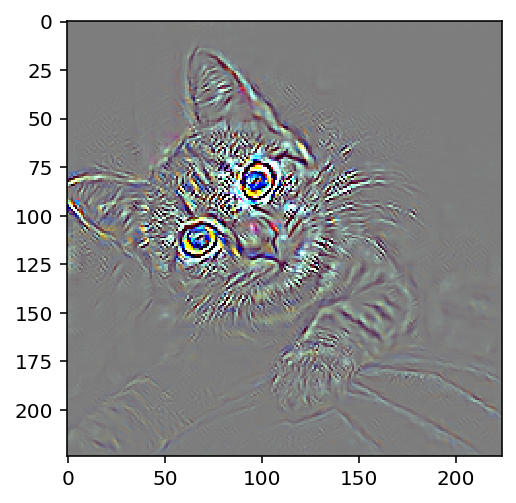

In [41]:
plt.imshow(saliency_map)